# Policy gradient algrorithm with BigDL

In [1]:
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from bigdl.dataset.transformer import Sample
from bigdl.nn.layer import *
from bigdl.util.common import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *

from rl.criterion import *

init_engine()

In [2]:
from keras import models
from keras.layers import Dense
from keras import optimizers

Using TensorFlow backend.


In [3]:
class PGAgent:
    def __init__(self, state_size, action_size, batch_size=32, gamma=0.95,learning_rate=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # discount rate
        self.learning_rate = learning_rate
        self.model = self._build_model()
        self.value_func = self._build_vf()
        self.memory = deque(maxlen=2000)
        self.batch_size = batch_size

    def _build_model(self):
        model = Sequential()

        model.add(Linear(self.state_size, 24))
        model.add(ReLU())

        model.add(Linear(24, 24))
        model.add(ReLU())

        model.add(Linear(24, 1))
        model.add(Sigmoid())
        return model
    
    def _build_vf(self):
        model = models.Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=optimizers.Adam(lr=0.001))
        return model
    
    def train_val_func(self):
        if len(self.memory) < self.batch_size:
            pass
        else:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                target = reward
                if not done:
                    target = (reward + self.gamma *
                              np.amax(self.value_func.predict(np.reshape(next_state, [1, state_size]))[0]))
                target_f = self.value_func.predict(np.reshape(next_state, [1, state_size]))
                target_f[0][action] = target
                self.value_func.fit(np.reshape(state, [1, state_size]), target_f, epochs=1, verbose=0)


    def act(self, state):
        result = self.model.forward(state)
        return 1 if result > np.random.random() else 0

In [4]:
import to_rdd

In [5]:
def play_game(agent, render=False):
    state = env.reset()
    memory = np.array([0,0,0,0])
    actions = np.array([])
    rewards = np.array([])
    for time in range(500):
        if render:
            env.render()
        memory = np.vstack((memory, state))
        action = agent.act(state)
        actions = np.append(actions, action)
        next_state, reward, done, _ = env.step(action)
        if done:
            reward = -10
        agent.memory.append((state, action, reward, next_state, done))
        if time==498:
            reward += 2+ np.amax(agent.value_func.predict(np.reshape(next_state, [1, 4])))
        rewards = np.append(rewards, reward)
        state = next_state
        if done or time == 498:
            break
    return memory[1:], actions, rewards, time

In [6]:
def running_reward(actions, rewards, st_values, gamma):
    result = []
    run_rew = 0
    for action, reward, st_value in list(zip(actions, rewards, st_values))[::-1]:
        run_rew = run_rew*gamma + reward
        result.append([action, (run_rew - st_value)])
    return np.vstack(result[::-1])

In [7]:
def get_values(agent, states):
    result = []
    for state in states:
        values = agent.value_func.predict(np.reshape(state, [1, agent.state_size]))[0]
        prediction = agent.model.forward(state)
        result.append(values[0]*(1-prediction) + values[1]*prediction)
    return result

In [8]:
def play_n_games(agent, n=20):
    X_batch = np.array([0,0,0,0])
    y_batch = np.array([0,0])
    results = []
    for i in range(n):
        a, b, c, d = play_game(agent)
        X_batch = np.vstack((X_batch, a))
        st_values = get_values(agent, a)
        y_batch = np.vstack((y_batch, running_reward(b, c, st_values, agent.gamma)))
        agent.train_val_func()
        results.append(d)
    return X_batch[1:], y_batch[1:], results

In [9]:
env = gym.make('CartPole-v1')
sc = SparkContext.getOrCreate(create_spark_conf())
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = PGAgent(state_size, action_size)

[2017-11-16 13:45:31,299] Making new env: CartPole-v1


creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createSigmoid


In [10]:
%%time
results = []
minimums = []
maximums = []
for t in range(1, 101):
    X_batch, y_batch, result = play_n_games(agent, n = 10)
    print(t, np.mean(result), np.var(result), result)
    results.append(np.mean(result))
    minimums.append(np.min(result))
    maximums.append(np.max(result))
    if np.mean(result) == 498:
        break
    rdd_sample = to_rdd.to_RDD(X_batch, y_batch, sc)
    batch_size = X_batch.shape[0] - X_batch.shape[0]%4
    optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=VanillaPGCriterion(),
                                  optim_method=Adam(learningrate=agent.learning_rate),
                                  end_trigger=MaxIteration(1),
                                  batch_size=batch_size)
    agent.model = optimizer.optimize()

1 18.1 60.49 [14, 28, 11, 25, 9, 16, 13, 18, 13, 34]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
2 30.3 390.01 [66, 50, 11, 14, 13, 11, 51, 22, 18, 47]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
3 16.3 15.21 [12, 17, 15, 12, 21, 15, 20, 24, 14, 13]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
4 20.6 30.44 [16, 12, 21, 15, 22, 28, 30, 17, 25, 20]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
5 20.8 112.36 [9, 18, 31, 19, 17, 45, 14, 30, 13, 12]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
6 26.3 301.01 [16, 23, 7, 31, 27, 20, 11, 73, 23, 32]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
7 16.7 153

KeyboardInterrupt: 

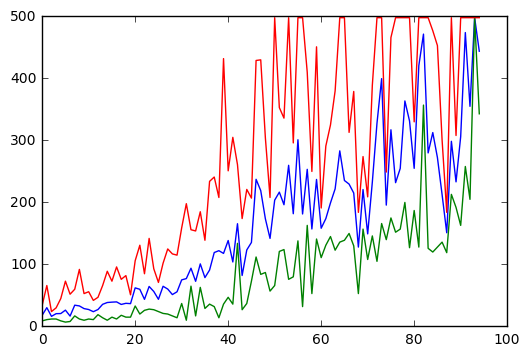

In [11]:
plt.plot(results)
plt.plot(minimums)
plt.plot(maximums)
plt.savefig('PGAC_BigDL_KerasVF_rew:-10_wo_Clip_2')
plt.show()

In [12]:
state = env.reset()
memory = np.array([0,0,0,0])
actions = np.array([])
rewards = np.array([])
for time in range(500):
    #memory = np.vstack((memory, state))
    value = agent.value_func.predict(np.reshape(state, [1,4]))
    prediction = agent.model.forward(state)
    rand = np.random.random()
    action = 1 if prediction > rand else 0
    next_state, reward, done, _ = env.step(action)
    print(value, prediction, rand, action)
    if done:
        reward = -10
    #rewards = np.append(rewards, reward)
    #agent.memory.append((state, action, reward, next_state, done))
    state = next_state
    if done or time == 498:
        break

[[ 21.94097328  21.99095917]] [ 0.60204738] 0.982900017178757 0
[[ 21.9828167   22.04873085]] [ 0.93409622] 0.5706508595407541 1
[[ 21.97083664  22.02025032]] [ 0.61550814] 0.03411672575098723 1
[[ 21.92576027  21.95652771]] [ 0.18061666] 0.02209600170668269 1
[[ 21.72286415  21.7758255 ]] [ 0.05892701] 0.14932270730726804 0
[[ 21.83520699  21.87281036]] [ 0.16274476] 0.8596037635630707 0
[[ 21.86545563  21.91884041]] [ 0.56378233] 0.4278364703032873 1
[[ 21.7854557   21.82752037]] [ 0.14975101] 0.06359620909679276 1
[[ 21.56525993  21.63121605]] [ 0.05291255] 0.5630124656774819 0
[[ 21.65904045  21.7114296 ]] [ 0.12522364] 0.49349709535122954 0
[[ 21.7210865   21.77529144]] [ 0.44222787] 0.16640829113305722 1
[[ 21.56919289  21.62982559]] [ 0.10771696] 0.3320336065334204 0
[[ 21.65779305  21.71035576]] [ 0.37503195] 0.8934541176705245 0
[[ 21.67219162  21.74158096]] [ 0.84905404] 0.25055375372830413 1
[[ 21.62946892  21.68121147]] [ 0.32680252] 0.701763239655611 0
[[ 21.6504879   21.7